In [1]:
%matplotlib inline
import sys
import os
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

- We build a dimensionality reduction method for spatiotemporal fields via the community detection algorithm INFOMAP. The datasets consists in 2 dimensional grids with timeseries embedded in it. Papers describing the Infomap and the Map equation (i.e., the theoretical framework behind it) are described in here.

- Differently from the previous algorithm I wrote (and available here: https://github.com/FabriFalasca/py-dMaps/tree/master/community_detection), here we allow the correlation metric to accept time series with nan data.

# In this notebook 

###  First: run the code
Here you give the main dataset to a function and you obtain your results.

###  Second: break the code in parts and explain it step by step
Here we break the code step by step

# Packages needed:

- networkx; find it here: https://networkx.org/
- Infomap; find it here: https://github.com/mapequation/infomap (easy to install). A description of the method behind infomap plus lots of papers is here: https://www.mapequation.org/publications.html#Rosvall-Axelsson-Bergstrom-2009-Map-equation 

In [2]:
import community_detection

# First: run the code

Here you see the main code. You feed the dataset "data" to "infomap_communities" 

Main function: infomap_communities

Inputs

(a) dataset: numpy array. Shape: [time, Y dimension, X dimension].

(b) p: percentage of nan allowed in a time series. 
E.g., p = 0.1 means
that no more than 10% of the values in each time series can be nans

(c) k: minimum correlation needed for 2 time series to be connected.
E.g., k = 0.3, would mean that two time series are linked if their Pearson 
correlation is larger than 0.3
The default k is k = None. In this case we consider all possible pairwise 
correlations and set k as a high quantile (q = 0.95) of the distribution.
However, it can be specified by the user and set to whatever value in between 
k = 0 and k = 1



In [3]:
# Import data
data = np.load('COBEv2_numpy.npy')

# Run community detection
p = 0.35

# If you want a specific k, just specify it (e.g., k = 0.5)
# If k = None, we choose k as a high quantile of the distribution of all pairwise correlations
community_map, single_communities, signals = community_detection.infomap_communities(data,p,k=None)

Percentage of time series considered: 70.96 %
K parameter set to: 0.3568782882776031
Community detection via Infomap
Found 18 communities


In [4]:
# Save results
np.save('./community_map.npy',community_map)
np.save('./single_communities.npy',single_communities)
np.save('./signals.npy',signals)

# Second: break the code in parts and explain it step by step

- In this notebook we show each single step on how the algorithm is built. The main code is then automated in some other python script, but here you see each step.

### Sections in this notebook

#### Building the algorithm...step by step

##### In "Step (b): import and preprocess dataset"  

- import dataset

- this dataset has no nans (apart from the land). Therefore, we simply introduce some nans in it randomly. This means that some time series will have blocks of nans data.

- We check how many nans are in a time series. If it is more than p percent than we set the all time series to nan, if not we keep that time series in the dataset. p is then an external parameter input by the user.

- We flatten the data array in this format: np.shape(flat_data): [number of time series, length of each time series]

##### In "Step (c): compute the correlation matrix"  

- Compute the correlation matrix. This matrix include all possible pairwise correlations between pairs of time series

- We consider only the upper triangle of the correlation matrix (and remove the diagonal). This because the matrix is symmetric. We then consider an high quantile of the remaining correlations (e.g., q = 0.95). This can help in estimating a threshold $K$ to threshold correlations

##### In "Step (d): compute the Adjacency matrix"  

- Threshold the correlation matrix with a threshold $K$. This threshold can either be chosen by the user or it can be chosen by the (super simple) heuristics found in the end of step (c)

##### In "Step (e): Find communities

- The graph is now encoded in the adjacency matrix. This is a undirect graph: if a link exists it is defined by a weight equal to 1, if a node does not exists we simply have zero. The Adjacency matrix is stored in a numpy array. We first define a networkX graph object from this array. Then we run the community detection algorithm infomap on the graph and identify the community structure.

- We then define:
    
    (i) domain_map: two dimensional array of the size [latitude, longitude] storing all communities
    
    (ii) single_domains: three dimensional array of size [# of communities, latitude, longitude] containing all domains. For each domain (e.g., single_domains[0] would be the first) grid points belonging to a domain are marked as 1. All the other points are "nan"s.
    
    (iii) signals: two dimensional array of size [# of communities, length of time series] containing all signals. The order of such signals is the same of the one found in the array single_domains. So the temporal variability of single_domains[n] will be in signals[n]. Each signal is computed as the average time series inside the domain. Nans are not considered in this computation.

# Building the algorithm...step by step

## Step (a): import all the libraries needed

In [5]:
import numpy as np
import scipy.io
import numpy.ma as ma
from scipy import signal, spatial
from scipy.spatial.distance import pdist,cdist, squareform
from collections import Counter

# Network libraries
import networkx as nx
import infomap
import preprocessing

## Step (b): import and preprocess dataset

In [6]:
############ ALEX: AS YOU SEE HERE I SAVED THE DATASET IN NUMPY. SO EVEN FOR EXAMPLES 
############ YOU DO NOT ACTUALLY HAVE TO LOAD THE NETCDF.
data = np.load('southwest30th.npy')
print(data.shape)
print(data)

(88, 350, 70)
[[[  7.36108274  -9.61012905  -0.89708887 ...          nan          nan
            nan]
  [-11.49594441 -13.10665131 -21.14778528 ...          nan          nan
            nan]
  [ -1.8796005   28.43485086  13.9521248  ...          nan          nan
            nan]
  ...
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]]

 [[  7.34598993  -9.5069899   -0.80593322 ...          nan          nan
            nan]
  [-11.56934663 -12.98075159 -21.23773355 ...          nan          nan
            nan]
  [ -1.77898045  28.46331879  14.12867701 ...          nan          nan
            nan]
  ...
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
          

In [7]:
##normalize time series to zero mean and unit variance
data = preprocessing.remove_mean(data)
data = preprocessing.remove_variance(data)

# Dimension of the field
dimX = np.shape(data)[2] # Points in X axis (long)
dimY = np.shape(data)[1] # Points in Y axis (lat)
dimT = np.shape(data)[0] # Points in time
print(data)

[[[ 0.48102938 -0.71725015 -0.06997874 ...         nan         nan
           nan]
  [-0.64153876 -0.82817187 -1.08854544 ...         nan         nan
           nan]
  [-0.10657126  1.37041103  0.72176058 ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]]

 [[ 0.48004311 -0.70955238 -0.062868   ...         nan         nan
           nan]
  [-0.64563502 -0.82021662 -1.09317538 ...         nan         nan
           nan]
  [-0.10086622  1.37178303  0.73089384 ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
      

In [8]:
############ ALEX: YOU DO NOT NEED THIS STEP AS YOU HAVE ALREADY NANS DATA ############
# Here I am simply trying to generate the nan data artificially

############################### IMPORTANT
# We are bulding a code able to deal with nan data
# This specific dataset DOES NOT have nans if not in the land.
# Therefore, we simply set random intervals of some of the time series to nan

import random

# Check: if a grid point is masked with nan at time t it should be masked at all t
for i in range(dimY):
    for j in range(dimX):
        # Define bounds
        a = random.randint(0, 100)
        b = random.randint(a+1, 200)
        data[a:b,i,j] = np.nan
        
#######################################################################################


print(data)

[[[ 0.48102938 -0.71725015 -0.06997874 ...         nan         nan
           nan]
  [-0.64153876 -0.82817187 -1.08854544 ...         nan         nan
           nan]
  [-0.10657126  1.37041103  0.72176058 ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]]

 [[ 0.48004311 -0.70955238 -0.062868   ...         nan         nan
           nan]
  [-0.64563502 -0.82021662 -1.09317538 ...         nan         nan
           nan]
  [-0.10086622  1.37178303  0.73089384 ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
      

In [9]:
############################### IMPORTANT
# Now, we consider ONLY time series with less than p% missing data

p = 0.30

check_ratios = []

# Check: if a grid point is masked with nan at time t it should be masked at all t
for i in range(dimY):
    for j in range(dimX):
        # number of nans
        n_nans = np.sum(np.isnan(data[:,i,j]))
        # ratio of nans
        ratio = n_nans/dimT
        check_ratios.append(ratio)
        if ratio > p: # if we have more nans than we want...
            data[:,i,j] = np.nan
check_ratios = np.array(check_ratios) 
# how many time series "made the cut"?
n_ts = np.sum(check_ratios < p)/len(check_ratios) # percent
print('Percentage of time series considered: '+str(np.round(n_ts*100,2))+' %')

Percentage of time series considered: 14.84 %


In [10]:
flat_data_masked = data.reshape(dimT,dimY*dimX).transpose()
print(flat_data_masked)

[[ 0.48102938  0.48004311 -1.93880585 ...  1.05067202 -0.06122414
   1.70217586]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


In [11]:
# indices where we have numbers (non-nans)
# it will be useful later to assign a community label to each grid point
#indices = np.where(~np.isnan(np.sum(flat_data_masked,axis=1)))[0]
indices = []
for i in range(len(flat_data_masked)):
    
    # number of nans
    n_nans = np.sum(np.isnan(flat_data_masked[i]))
    # if this is equal to the length of the time series
    # then this time series is all nan and it is useless to us
    # if not, we save the index
    if n_nans < dimT:
        indices.append(i)
        
indices = np.array(indices)        

In [12]:
flat_data = flat_data_masked[indices]
print(flat_data)

[[ 0.48102938  0.48004311 -1.93880585 ...  1.05067202 -0.06122414
   1.70217586]
 [ 1.0604459   1.05748457 -0.55329193 ...  0.58696477  1.91460909
  -2.74547204]
 [ 1.53849184  1.53566929 -1.94156777 ...  0.00807865  1.4942909
  -1.08952529]
 ...
 [        nan         nan  0.696628   ... -1.06211926 -1.33391356
   1.51431906]
 [        nan         nan  1.70231638 ...  0.59535953  0.88362115
   0.22022749]
 [        nan         nan         nan ...         nan  1.77179571
  -0.51665177]]


## Step (c): compute the correlation matrix

Define function to compute correlation between two time series with nans. 

Important: the time series are assumed to be standardized to zero mean and unit variance.
(Just to be sure we add this step in the main code)

In [13]:
import pandas as pd
df = pd.DataFrame(np.transpose(flat_data))
rho = df.corr()
corr_matrix = np.array(rho)

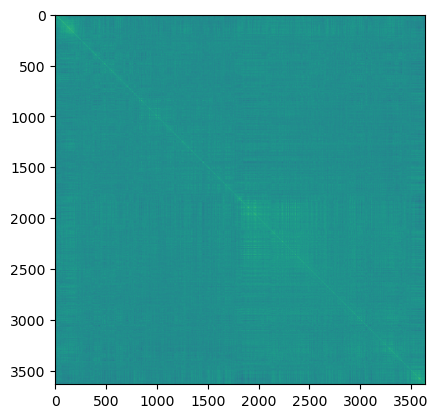

In [14]:
plt.imshow(corr_matrix)

0.95 quantile of the correlation function is: 0.33520373176846113


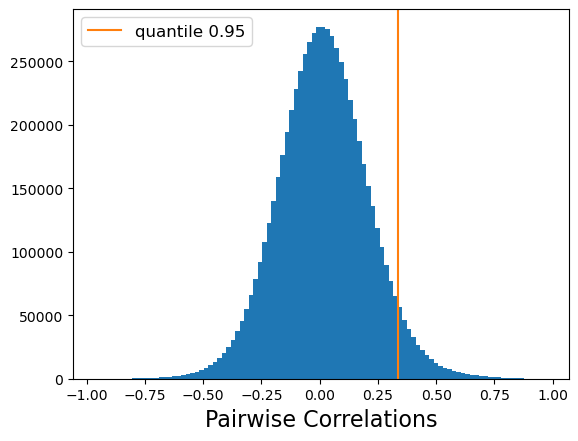

In [15]:
# Let's consider the histogram of all correlations
# To do so we consider only the upper triangle 
# of the correlation matrix
upper_triangle = np.triu(corr_matrix)
upper_triangle = upper_triangle[upper_triangle!=0]
upper_triangle = upper_triangle[upper_triangle!=1]

print('0.95 quantile of the correlation function is: '+str(np.quantile(upper_triangle,0.95)))

_ = plt.hist(upper_triangle,100)
plt.xlabel('Pairwise Correlations',fontsize = 16)
plt.axvline(np.quantile(upper_triangle,0.95),c = 'tab:orange',label = 'quantile 0.95')
plt.legend(fontsize=12)

## Step (d): compute the Adjacency Matrix

In [16]:
K = np.quantile(upper_triangle,0.95)
print(K)

0.33520373176846113


In [17]:
adj_matrix = community_detection.compute_adj_m(corr_matrix,K)

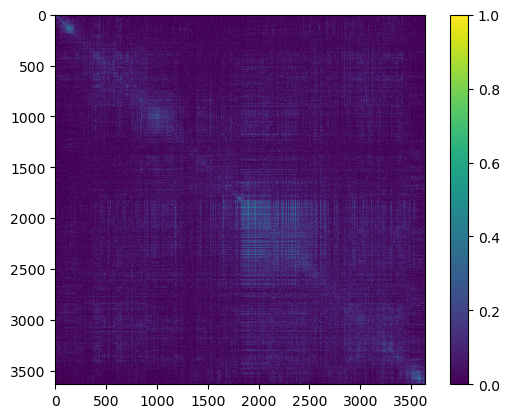

In [18]:
plt.imshow(adj_matrix); plt.colorbar()

## Step (e): Find communities

In [19]:
import numpy as np
import networkx as nx
graph = nx.Graph(adj_matrix)

In [20]:
im = infomap.Infomap("--two-level --verbose --silent")

In [21]:
for e in graph.edges():
    im.addLink(*e)

In [22]:
im.run()
print(f"Found {im.num_top_modules} communities")

Found 5 communities


In [23]:
# List of nodes ids
nodes = []
# List of respective community
communities = []

In [24]:
for node, module in im.modules:

    nodes.append(node)
    communities.append(module)

partition = np.transpose([nodes,communities])

# How many communities?
n_com = np.max(partition[:,1])

In [25]:
# Compute an average signal from each community

# Step (a)
# In modes_indices we store the indices of nodes belonging to each community
#  e.g., modes_indices[0] will contain all nodes in community 0 etc.
modes_indices = []
for i in np.arange(1,n_com+1):
    modes_indices.append(partition[partition[:,1]==i][:,0])
#modes_indices = np.array(modes_indices)

# Now compute the signals of each community as the cumulative anomaly inside
signals = []
for i in range(len(modes_indices)):
    # Extract the mode
    extract_mode = np.array(flat_data)[modes_indices[i]]
    # Compute the signal as the mean time series (nans are not considered)
    signal = np.nanmean(extract_mode,axis=0)
    # Store the result
    signals.append(signal)

signals = np.array(signals)

In [26]:
# Let's embed the results on the grid
# for now this domain maps is flattened
domains_grid_flattened = flat_data_masked[:,0] # at time t = 0
domains_grid_flattened[indices] = partition[:,1]# these are the labels
domain_map = domains_grid_flattened.reshape(dimY,dimX)

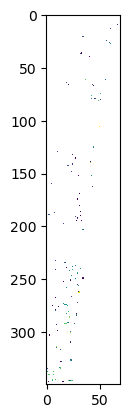

In [27]:
plt.imshow(np.flipud(domain_map))

In [28]:
# Finally, let's also save single domain maps
# Output:
# For each domain we have a 2-Dimensional map where grid points belonging to the domain have value 1
# points that do not belong to the domain have are nan
single_domains = []

for i in range(n_com):
    i = i + 1 # labels start from 1 not from 0
    domain = domain_map.copy()
    domain[domain!=i]=np.nan
    domain[domain==i]=1
    single_domains.append(domain)
single_domains = np.array(single_domains)

## Plotting domains and signals together

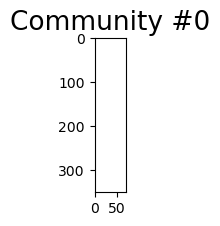

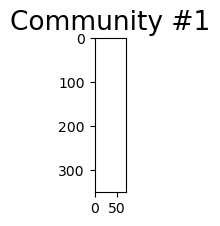

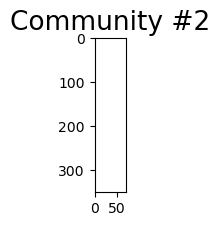

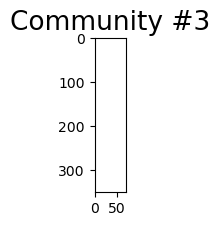

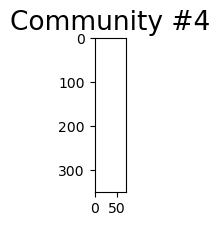

In [29]:
# For plotting define a new array with np.nan instead of zeros

# Let's look at all average signals
for i in range(len(signals)):
    
    
    fig = plt.figure(figsize=(15,2))

    ax = fig.add_subplot(121)  


    plt.imshow(np.flipud(single_domains[i]),cmap=plt.cm.prism)
    #cb=plt.colorbar(location='bottom',aspect=20,pad=0.08)
    #cb.ax.tick_params(labelsize=37)
    
    # Plot domain id
    plt.title('Community #'+str(i), fontsize = 19)

    
    #ax = fig.add_subplot(122)  
    
    #plt.plot(signals[i],"-k",linewidth = 2)
    #plt.xlabel('t [yr]',fontsize = 20)
    #ax.set_xticks([0,60,120,180,240,300,360,420])
    #ax.set_xticklabels(['1980','1985','1990','1995','2000','2005','2010','2015'])
    #plt.ylabel('SSTa',fontsize = 20)
    #plt.xticks(fontsize = 14)
    #plt.yticks(fontsize = 14)
    
    #plt.subplots_adjust(wspace=0.3, hspace=0)
    
    
    #plt.show()



In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Create a directory to save the plots if it doesn't already exist
import os
output_dir = 'output_plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(signals)):
    fig = plt.figure(figsize=(15, 2))
    ax = fig.add_subplot(121)
    
    plt.imshow(np.flipud(single_domains[i]), cmap=plt.cm.prism)
    plt.title('Community #' + str(i), fontsize=19)
    file_name = os.path.join(output_dir, f'community_{i}_part.png')
    plt.savefig(file_name, bbox_inches='tight')
    
    plt.close()



